In [86]:
import iris
import numpy

import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt

In [87]:
%matplotlib inline

In [88]:
infile = '/g/data/ua6/DRSv2/CMIP5/NorESM1-M/historical/mon/ocean/r1i1p1/hfds/latest/hfds_Omon_NorESM1-M_historical_r1i1p1_185001-200512.nc'

In [89]:
cube = iris.load_cube(infile, 'surface_downward_heat_flux_in_sea_water')

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'hfds'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [90]:
print(cube)

surface_downward_heat_flux_in_sea_water / (W m-2) (time: 1872; cell index along second dimension: 384; cell index along first dimension: 320)
     Dimension coordinates:
          time                                         x                                        -                                      -
          cell index along second dimension            -                                        x                                      -
          cell index along first dimension             -                                        -                                      x
     Auxiliary coordinates:
          latitude                                     -                                        x                                      x
          longitude                                    -                                        x                                      x
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/

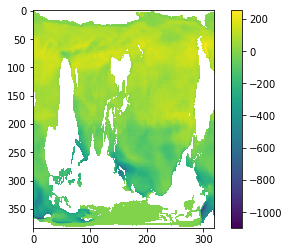

In [91]:
#qplt.contourf(cube[0, ::])
#plt.show()

fig, ax = plt.subplots()
im = ax.imshow(cube[0, ::].data)
fig.colorbar(im)

plt.show()

In [92]:
cube.data.mean()

-1.1515694228987592

In [93]:
aux_coord_names = [coord.name() for coord in cube.aux_coords]
print(aux_coord_names)

['latitude', 'longitude']


In [94]:
lat_subset = lambda cell: cell >= 0.0    
lat_constraint = iris.Constraint(latitude=lat_subset)

In [95]:
cube.extract(lat_constraint)

CoordinateMultiDimError: Cannot apply constraints to multidimensional coordinates

So I need to make a mask instead of using a constraint...

In [96]:
def create_mask(latitude_array, target_shape, hemisphere):
    """Create mask from the latitude auxillary coordinate"""

    target_ndim = len(target_shape)

    if hemisphere == 'nh':
        mask_array = numpy.where(latitude_array >= 0, False, True)
    elif hemisphere == 'sh':
        mask_array = numpy.where(latitude_array < 0, False, True)

    mask = broadcast_array(mask_array, [target_ndim - 2, target_ndim - 1], target_shape)
    assert mask.shape == target_shape 

    return mask


def broadcast_array(array, axis_index, shape):
    """Broadcast an array to a target shape.
    
    Args:
      array (numpy.ndarray)
      axis_index (int or tuple): Postion in the target shape that the 
        axis/axes of the array corresponds to
          e.g. if array corresponds to (depth, lat, lon) in (time, depth, lat, lon)
          then axis_index = [1, 3]
          e.g. if array corresponds to (lat) in (time, depth, lat, lon)
          then axis_index = 2
      shape (tuple): shape to broadcast to
      
    For a one dimensional array, make start_axis_index = end_axis_index
    
    """

    if type(axis_index) in [float, int]:
        start_axis_index = end_axis_index = axis_index
    else:
        assert len(axis_index) == 2
        start_axis_index, end_axis_index = axis_index
    
    dim = start_axis_index - 1
    while dim >= 0:
        array = array[numpy.newaxis, ...]
        array = numpy.repeat(array, shape[dim], axis=0)
        dim = dim - 1
    
    dim = end_axis_index + 1
    while dim < len(shape):    
        array = array[..., numpy.newaxis]
        array = numpy.repeat(array, shape[dim], axis=-1)
        dim = dim + 1

    return array

In [97]:
cube.coord('latitude').points

array([[-79.22052002, -79.22052002, -79.22052002, ..., -79.22052002,
        -79.22052002, -79.22052002],
       [-78.68630981, -78.68630981, -78.68630981, ..., -78.68630981,
        -78.68630981, -78.68630981],
       [-78.15209198, -78.15209198, -78.15209198, ..., -78.15209198,
        -78.15209198, -78.15209198],
       ..., 
       [ 71.29031372,  71.29408264,  71.30160522, ...,  71.30160522,
         71.29408264,  71.29031372],
       [ 71.73524475,  71.73881531,  71.74596405, ...,  71.74596405,
         71.73881531,  71.73524475],
       [ 72.18597412,  72.18933105,  72.19603729, ...,  72.19603729,
         72.18933105,  72.18597412]], dtype=float32)

In [98]:
cube.shape

(1872, 384, 320)

In [99]:
type(cube.data)

numpy.ma.core.MaskedArray

In [100]:
nh_mask = create_mask(cube.coord('latitude').points, cube.shape, 'nh')
ocean_mask = cube.data.mask

complete_mask = nh_mask + ocean_mask

In [101]:
cube.data = numpy.ma.asarray(cube.data)
cube.data.mask = complete_mask

In [102]:
cube.data.mean()

-7.020794134395608

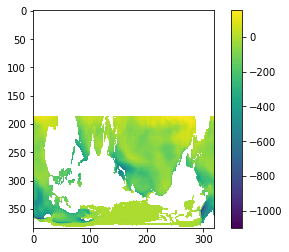

In [103]:
fig, ax = plt.subplots()
im = ax.imshow(cube[0, ::].data)
fig.colorbar(im)

#qplt.contourf(cube[0, ::])
#plt.gca().coastlines()
plt.show()